Divide $0 \leq x \leq 1$ into $N$ intervals, each of size $\delta x \equiv 1/N$. The aim is to march the solution forward in time for various time steps $\delta t$.

We consider three schemes.

1.  Approximate $\theta_t$ by a forward difference in time and $\theta_{xx}$ by a spatial central difference at the current time, which gives the numerical scheme
\begin{equation}
    \frac{\theta_n^{m+1} - \theta_n^m}{\delta t} = (\delta^2 \theta)_n^m \equiv \frac{\theta_{n+1}^m - 2\theta_n^m + \theta_{n-1}^m}{(\delta x)^2},
\end{equation}
where $\theta_n^m$ is an approximation to $\theta(n\delta x, m\delta t)$.
2.   Approximate $\theta_t$ instead by a central difference in time, so that
\begin{equation}
    \frac{\theta_n^{m+1} - \theta_n^{m-1}}{2\delta t} = (\delta^2 \theta)_n^m.
\end{equation}
In this case you will need scheme (1.) in order to make the first step
3.  Modify scheme (1.) to
\begin{equation}
    \frac{\theta_n^{m+1} - \theta_n^m}{\delta t} = \rho (\delta^2 \theta)_n^{m+1} + (1-\rho) (\delta^2 \theta)_n^m.
\end{equation}
with $0 < \rho \leq 1$. 6 1. This is now an implicit method, and at each step $(N+1)$ simultaneous equations have to be solved for the $\theta_n^{m+1}$. The matrix associated to these equation is tridiagonal, hence sparse, which can be solved efficiently using Thomas' algorithm.

*   When $\rho = 0$, this scheme reduces to the FTCS method in (1.).
*   When $\rho = 0.5$, this is the Crank-Nicolson method.
*   When $\rho = 1$, this is the fully implicit backward-time, central-space (BTCS) method.

Introduce the Courant number $\nu = \delta t / (\delta x)^2$. Then our schemes can be written as:
1.  $\theta_n^{m+1} = \theta_n^m + \nu (\theta_{n+1}^m - 2\theta_n^m + \theta_{n-1}^m)$;
2.  $ \theta_n^{m+1} = \theta_n^{m-1} + 2\nu (\theta_{n+1}^m - 2\theta_n^m + \theta_{n-1}^m) $;
3. $ -\rho\nu \theta_{n-1}^{m+1} + (1 + 2\rho\nu) \theta_n^{m+1} - \rho\nu \theta_{n+1}^{m+1} = (1-\rho)\nu \theta_{n-1}^m + (1 - 2(1-\rho)\nu) \theta_n^m + (1-\rho)\nu \theta_{n+1}^m $.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

def f(t):
    '''
    Boundary condition function f(t) = t(1-t)
    '''
    return t * (1 - t)

def Bn_analytic(n, t):
    '''
    Computes the nth Fourier coefficient B_n(t).
    '''
    if n == 0:
        return 0  # Fourier sine series starts from n = 1.
    pi = np.pi
    factor = 2 / (n**5 * pi**5)
    term_1 = 2 * t * n**2 * pi**2
    term_2 = - n**2 * pi**2
    term_3 = - 2
    term_4 = (n**2 * pi**2 + 2)
    exp_factor = np.exp(-n**2 * pi**2 * t)
    return factor * (term_1 + term_2 + term_3 + term_4 * exp_factor)

def theta_analytic(x, t, num_terms=200):
    '''
    Computes the full analytic solution.
    '''
    if t <= 0:
        return 0.0
    phi_sum = sum(Bn_analytic(n, t) * np.sin(n * np.pi * x) for n in range(1, num_terms + 1))
    return f(t) * (1 - x) + phi_sum

In [17]:
def solve_scheme_1_ftcs(N, nu, t_target):
    '''
    Solves using Scheme (1): Forward Time, Central Space (FTCS).
    '''
    dx = 1.0 / N
    dt = nu * dx**2
    num_steps = int(round(t_target / dt))

    theta = np.zeros(N + 1)  # Initial condition at t = 0.

    for m in range(num_steps):
        t_next = (m + 1) * dt

        theta_next = theta.copy()
        theta_next[1:-1] = theta[1:-1] + nu * (theta[2:] - 2 * theta[1:-1] + theta[:-2])

        # Apply boundary conditions.
        theta_next[0] = f(t_next)
        theta_next[-1] = 0

        # Update the solution.
        theta = theta_next

    return theta

In [18]:
def solve_scheme_2_leapfrog(N, nu, t_target):
    '''
    Solves using Scheme (2): Central Time, Central Space (Leapfrog).
    '''
    dx = 1.0 / N
    dt = nu * dx**2
    num_steps = int(round(t_target / dt))

    # Need two previous time steps.
    theta_prev = np.zeros(N + 1)  # Solution at t = m - 1.
    theta_curr = np.zeros(N + 1)  # Solution at t = m.

    # First step using FTCS (Scheme 1).
    theta_curr[1:-1] = theta_prev[1:-1] + nu * (theta_prev[2:] - 2 * theta_prev[1:-1] + theta_prev[:-2])
    theta_curr[0] = f(dt)
    theta_curr[-1] = 0

    for m in range(1, num_steps):
        t_next = (m + 1) * dt

        theta_next = theta_prev.copy() # Start with theta_m-1.
        theta_next[1:-1] += 2 * nu * (theta_curr[2:] - 2 * theta_curr[1:-1] + theta_curr[:-2])

        # Apply boundary conditions.
        theta_next[0] = f(t_next)
        theta_next[-1] = 0

        # Update the solution.
        theta_prev = theta_curr.copy()
        theta_curr = theta_next

    return theta_curr

In [19]:
def solve_scheme_3_implicit(N, nu, rho, t_target):
    '''
    Solves using Scheme (iii): General Implicit Method.
    '''
    dx = 1.0 / N
    dt = nu * dx**2
    num_steps = int(round(t_target / dt))

    theta = np.zeros(N + 1) # Initial condition.

    N_internal = N - 1

    # Setup the left-hand side matrix.
    A_diag = (1 + 2 * rho * nu) * np.ones(N_internal)
    A_upper = -rho * nu * np.ones(N_internal - 1)
    A_lower = -rho * nu * np.ones(N_internal - 1)
    A_banded = np.vstack([np.append(0, A_upper), A_diag, np.append(A_lower, 0)])

    for m in range(num_steps):
        t_next = (m + 1) * dt

        # Setup the right-hand side vector.
        b = (1 - rho) * nu * theta[:-2] + \
            (1 - 2 * (1 - rho) * nu) * theta[1:-1] + \
            (1 - rho) * nu * theta[2:]

        # Apply boundary conditions.
        b[0] += rho * nu * f(t_next)

        # Solve the tridiagonal system.
        theta_internal_next = solve_banded((1, 1), A_banded, b)

        # Update the solution.
        theta[1:-1] = theta_internal_next
        theta[0] = f(t_next)
        theta[-1] = 0

    return theta

Comparison of Numerical Schemes at t = 0.1
-------------------------------------------------------------------------------------------------------------
x      | Analytic     | Scheme (1)   | Error (1)    | Scheme (2)   | Error (2)    | Scheme (3)   | Error (3)   
-------------------------------------------------------------------------------------------------------------
0.00   | 0.09000000   | 0.09000000   | 0.00000000   | 0.09000000   | 0.00000000   | 0.09000000   | 0.00000000  
0.20   | 0.04262213   | 0.04160000   | -0.00102213  | -0.16160000  | -0.20422213  | 0.04295496   | 0.00033283  
0.40   | 0.01776396   | 0.01655000   | -0.00121396  | 0.21640000   | 0.19863604   | 0.01832951   | 0.00056555  
0.60   | 0.00643046   | 0.00480000   | -0.00163046  | -0.07920000  | -0.08563046  | 0.00697162   | 0.00054116  
0.80   | 0.00190052   | 0.00122500   | -0.00067552  | 0.01960000   | 0.01769948   | 0.00221426   | 0.00031374  
1.00   | -0.00000000  | 0.00000000   | 0.00000000   | 0.00000000 

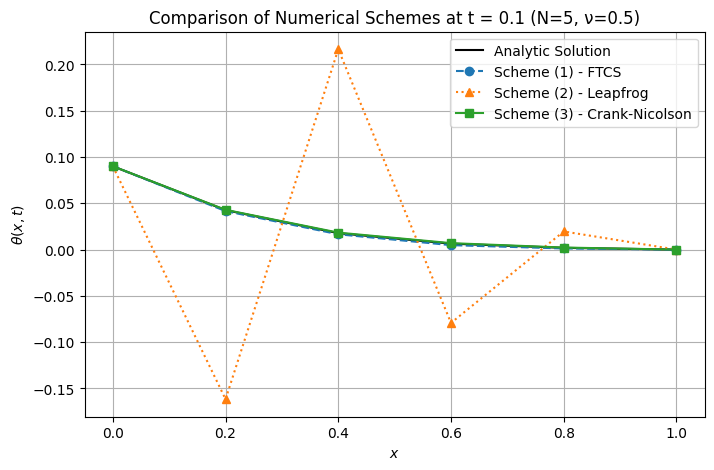

In [20]:
# Parameters
N = 5 # N = 5, 20, 80
nu = 0.5 # nu = 1/12, 1/6, 1/3, 1/2, 2/3, 1
rho = 0.5
t_target = 0.1
x_grid = np.linspace(0, 1, N + 1)

# Run all schemes
theta_1 = solve_scheme_1_ftcs(N, nu, t_target)
theta_2 = solve_scheme_2_leapfrog(N, nu, t_target)
theta_3 = solve_scheme_3_implicit(N, nu, rho, t_target)
theta_an = np.array([theta_analytic(xi, t_target) for xi in x_grid])

# Calculate errors
error_1 = theta_1 - theta_an
error_2 = theta_2 - theta_an
error_3 = theta_3 - theta_an

# Tabulation
print("Comparison of Numerical Schemes at t = 0.1")
print("-" * 109)
print(f"{'x':<6} | {'Analytic':<12} | {'Scheme (1)':<12} | {'Error (1)':<12} | {'Scheme (2)':<12} | {'Error (2)':<12} | {'Scheme (3)':<12} | {'Error (3)':<12}")
print("-" * 109)
for i in range(len(x_grid)):
    print(f"{x_grid[i]:<6.2f} | "
          f"{theta_an[i]:<12.8f} | "
          f"{theta_1[i]:<12.8f} | {error_1[i]:<12.8f} | "
          f"{theta_2[i]:<12.8f} | {error_2[i]:<12.8f} | "
          f"{theta_3[i]:<12.8f} | {error_3[i]:<12.8f}")
print("-" * 109)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x_grid, theta_an, 'k-', label='Analytic Solution')
plt.plot(x_grid, theta_1, 'o--', label='Scheme (1) - FTCS')
plt.plot(x_grid, theta_2, '^:', label='Scheme (2) - Leapfrog')
plt.plot(x_grid, theta_3, 's-', label='Scheme (3) - Crank-Nicolson')

plt.title(f'Comparison of Numerical Schemes at t = {t_target} (N={N}, ν={nu})')
plt.xlabel(f'$x$')
plt.ylabel(f'$\\theta(x, t)$')
plt.legend()
plt.grid(True)
plt.show()

1.  The FTCS scheme has a strict conditional stability boundary at $\nu = 0.5$. The numerical solution grows without bound for larger $\nu$ whilst it is stable for $\nu < 0.5$. The error depends on both step and grid spacing, so a smaller $\nu$ does not necessarily result in a smaller error. It is first order accurate in time and second order accurate in space.
2.  The leapfrog scheme failed for all parameter combinations, indicating divergence and unconditional unstability.
3.  Both the Crank-Nicolson $\rho = 0.5$ and the fully implicit schemes $\rho = 1$ are stable for all values of $\nu$, but the Crank-Nicolson scheme is more accurate than the fully implicit scheme. Indeed, the scheme is conditionally stable for $0 \leq \rho < 0.5$ and unconditionally stable for $0.5 \leq \rho \leq 1$. In general, this scheme is first order accurate in time and second order accurate in space, but the special case of the Crank-Nicolson scheme also has second order accuracy in time.

In the special case for scheme (1) where $\nu = 1/6$, the leading term of the local truncation error for FTCS is:
\begin{equation}
     \text{LTE} = \left( \frac{\delta t}{2} - \frac{(\delta x)^2}{12} \right) \frac{\partial^4 \theta}{\partial x^4} + \dots
\end{equation}
If we set this term to zero, then
\begin{equation}
    \frac{\delta t}{2} = \frac{(\delta x)^2}{12} \implies \nu = \frac{\delta t}{(\delta x)^2} = \frac{2}{12} = \frac{1}{6}
\end{equation}
For this specific value of $\nu$, the leading error term vanishes, and the scheme becomes exceptionally accurate, with an error of $O((\delta x)^4)$.

For large $\nu$, while the Crank-Nicolson scheme is unconditionally stable, it is actually not as effective at dampening high frequency osciallations as the fully implicit scheme. When a large time step is used, and the solution has rapid changes, small, non-growing oscillations can appear in the numerical solution. This is because the scheme is not L-stable.

Consider the case now where $\delta t = \mu \delta x$, so the time step is linearly related to the space step. Then this yields
\begin{equation}
    \nu = \frac{\delta t}{(\delta x)^2} = \frac{\mu \delta x}{(\delta x)^2} = \frac{\mu}{\delta x}.
\end{equation}
As we refine the grid $\delta x \to infty$, the Courant number goes to infinity $\nu \to \infty$. For scheme (1), this would always violate the stability condition $\nu \leq 0.5$ but for scheme (3) with $\rho \geq 0.5$, this is not a problem.